<a href="https://colab.research.google.com/github/kjh8331267/News_NLP_Test/blob/main/hdbscan_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering News Articles with HDBSCAN
- Tokenizer: mecab
- Text Embedding : kpf-sbert
    - bert모델을 국내뉴스로 학습한 모델
- Dimension Reduction : umap
- Clustering : HDBSCAN
- [추후 적용하고 싶은 시각화](https://www.nlplanet.org/course-practical-nlp/02-practical-nlp-first-tasks/12-clustering-articles)

## Setting

In [1]:
# 필요한 라이브러리 설치
# !pip install konlpy
!pip install sentence_transformers
# SentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings
!pip install umap-learn
!pip install hdbscan


  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 55.1 MB/s eta 0:00:00


In [ ]:
# mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

In [6]:
ls

Mecab-ko-for-Google-Colab/  sample_data/


In [7]:
cd Mecab-ko-for-Google-Colab/

/content/Mecab-ko-for-Google-Colab


In [8]:
ls

images/                             install_mecab-ko_on_colab_light_220429.sh  README.md
install_mecab-ko_on_colab190912.sh  LICENSE


In [ ]:
!bash install_mecab-ko_on_colab_light_220429.sh

## Load Library

In [11]:
import pandas as pd
import numpy as np
import re
import itertools
from datetime import datetime
# import konlpy
import matplotlib.pyplot as plt

In [12]:
from konlpy.tag import Mecab
mecab = Mecab()
print(mecab.nouns('안녕반가워 나는 명사일까 noun일까?'))
# NameError: name 'Tagger' is not defined 오류 발생시
#     -> [런타임] - [세션관리] 메뉴로 팝업을 호출 한뒤에, 현재 실행중인 세션을 "종료" 한 뒤 다시 연결하여 처음부터 다시 실행

['나', '명사']


In [13]:
from sentence_transformers import SentenceTransformer
model_name = 'bongsoo/kpf-sbert-128d-v1'
model = SentenceTransformer(model_name)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.55k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/456M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/369 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/276k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/395k [00:00<?, ?B/s]

## define function

In [14]:
def text_cleaning(doc): # 토큰나이징 전에 영문, 특수문자, 숫자 제거 및 기타 단어 변환


    # 한국어와 문장을 구분하는 '.'를 제외한 글자를 제거
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 .]", "", doc)

    # 기타 문자 변환
    doc = re.sub("서울경제|매일경제|한국경제|주간\s*경제지표|특징주|블룸버그\s*통신|로이터\s*통신", "", doc)
    doc = re.sub("이 기사는 국내 최대 해외 투자정보 플랫폼 한경 글로벌마켓에 게재된 기사입니다.", "", doc)
    doc = re.sub("이 기사는 프리미엄 스타트업 미디어 플랫폼 한경 긱스에 게재된 기사입니다.", "", doc)
    doc = re.sub("한국경제신문의 프리미엄 스타트업 미디어 플랫폼 긱스(Geeks)가", "", doc)
    doc = re.sub("이 기사는 국내 최대 해외 투자정보 플랫폼 한경 글로벌마켓에 게재된 기사입니다.", "", doc)
    doc = re.sub("스타트업 뉴스를 브리핑합니다.", "", doc)
    doc = re.sub("프리미엄 스타트업 미디어 플랫폼", "", doc)
    doc = re.sub("매경 라이징 임팩트", "", doc)
    doc = re.sub("...기자|... 기자|... ?기자", "", doc)
    doc = re.sub("마켓워치", "", doc)
    doc = re.sub("현지시간", "", doc)
    doc = re.sub("글로벌 리서치", "", doc)
    doc = re.sub("게티 이미지 뱅크|게티이미지 뱅크|게티 이미지뱅크|게티이미지뱅크", "", doc)
    doc = re.sub("이메일|카카오톡|제보|제보하기|전화|검색|채널 추가|유튜브 구독|네이버 유튜브|전화 추가|뉴스를 구독해주세요", "", doc)
    doc = re.sub("영상 편집|영상편집|영상 취재|영상취재|여러분의 제보를 기다립니다|제보", "", doc)
    doc = re.sub("이벤트 금지", "", doc)
    doc = re.sub("뉴스\s*스탠드|재배포\s*금지|무단\s*전재|소통\s*커뮤니티|경향\s*신문|영상\s*취재|영상\s*편집|카카오톡|전화|이메일|앵커|뉴스데스크|뉴스|제보", "", doc)
    return doc

## Load data and Preprocessing

In [20]:
data_path = '/content/drive/MyDrive/issue_trends/news_202208.csv'
df_raw_data = pd.read_csv(data_path)

# 기사내용 nan인 행 제거
df_raw_data = df_raw_data.dropna(subset = ['content']).reset_index()
df_raw_data = df_raw_data.drop_duplicates(subset = ["title"]) # 겹치는 뉴스 제거
df_raw_data = df_raw_data.drop_duplicates(subset = ["content"]) # 겹치는 뉴스 제거

drop_text = ['[표]', '[데이터로 보는 증시]']
for i in drop_text:
    doc_boolean_tmp = list(map(lambda x: i not in x, df_raw_data.title))
    df_raw_data = df_raw_data.loc[doc_boolean_tmp, :]

SW = set()
with open('/content/drive/MyDrive/stopwords-ko.txt', encoding="utf-8") as f:
    for word in f:
        SW.add(word.strip())

- Select a sentence or title as input data

In [18]:
# 기사 본문을 문장으로 실시
#
df_data = df_raw_data.content
lst_sent_all = [text_cleaning(doc).split(". ") for doc in df_data]
lst_sent_all = list(itertools.chain(*lst_sent_all))

import random
lst_sent = random.sample(lst_sent_all, 500)
print(len(lst_sent))

500


In [ ]:
# 제목으로 실시
df_data = df_raw_data.title
lst_sent_all = [text_cleaning(doc) for doc in df_data]

import random
lst_sent = random.sample(lst_sent_all, 500)
print(len(lst_sent))

500


## Tokenizing

In [47]:
lst_sent_noun = [' '.join([word for word in mecab.nouns(doc) if word not in SW and len(word) > 1] ) for doc in lst_sent]

In [51]:
print(lst_sent[1])
print(mecab.nouns(lst_sent[1]))
print(lst_sent_noun[1])

전용  기준으로 서울 강남구 대치동 아이파크의 경우 계약갱신청구권을 사용한 경우 평균 전셋값이 억만원에서 억만원으로 약  오르는 데 그쳤지만 계약갱신청구권을 사용하지 않은 경우 전셋값이 억원에서 억원으로 
['전용', '기준', '서울', '강남구', '대치동', '아이파크', '경우', '계약', '갱신', '청구', '사용', '경우', '평균', '전셋값', '억만', '원', '억만', '원', '약', '데', '계약', '갱신', '청구', '사용', '경우', '전셋값', '억', '원', '억', '원']
전용 기준 서울 강남구 대치동 아이파크 경우 계약 갱신 청구 사용 경우 평균 전셋값 억만 억만 계약 갱신 청구 사용 경우 전셋값


## Text Embedding

In [52]:
corpus_embeddings = model.encode(lst_sent_noun)
print(corpus_embeddings)

[[ 0.0624674   0.04199739 -0.09978057 ...  0.23160158  0.28343654
   0.05461393]
 [-0.16829005  0.06233767 -0.36605462 ...  0.0026977  -0.10565961
   0.21870054]
 [-0.16057469 -0.08831848 -0.52585953 ...  0.03434545 -0.0744513
   0.14220937]
 ...
 [ 0.21880081  0.1008452  -0.2616503  ... -0.13610052 -0.29158232
  -0.13112204]
 [ 0.17843598  0.09789172 -0.00552634 ... -0.13646515 -0.09627771
  -0.19763856]
 [ 0.02146245 -0.01941378 -0.00755304 ...  0.05869628 -0.22842547
   0.09753738]]


## Dimension Reduction

In [53]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=3,
                            metric='cosine').fit_transform(corpus_embeddings)

In [54]:
print(corpus_embeddings.shape, '  ->  ', umap_embeddings.shape)

(500, 128)   ->   (500, 3)


## Clustering

In [63]:
import hdbscan

cluster = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(umap_embeddings) #corpus_embeddings

docs_df = pd.DataFrame(lst_sent_noun, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

docs_df.Topic.value_counts().sort_index()

Topic
-1     216
 5      45
 12     31
 8      27
 1      21
 16     17
 14     16
 6      13
 7      12
 13     12
 11     11
 17     10
 15     10
 18      9
 10      9
 4       9
 3       8
 9       8
 2       8
 0       8
Name: count, dtype: int64

In [70]:
docs_df.Topic.value_counts().sort_index()

Topic
-1     216
 0       8
 1      21
 2       8
 3       8
 4       9
 5      45
 6      13
 7      12
 8      27
 9       8
 10      9
 11     11
 12     31
 13     12
 14     16
 15     10
 16     17
 17     10
 18      9
Name: count, dtype: int64

In [64]:
docs_per_topic.Doc[0]

'연합 자료 사진 세종 연합 올해 지난달 물가 브룩필드 머티 리얼 플러스 설비 부사장 주도 신한 자산운용 분배 전날 지난달 해당 보유 투자자 주당 분배금 지급 안심 전환 대출 금리 산정 근거 보금자리 금리 포인트 보금자리 대비 안심 전환 대출 우대금리 기존 포인트 포인트 확대 안심 전환 대출 금리 당초 예상 대비 풀이 연구원 지분 보유 공시 이후 차익 실현 발생 조정 반등 고가 경신 그룹 신사업 영역 지속 가능 헬스 앤드 니스 모빌리티 라이프 플랫폼 중심 추가 사업 추진 기대감 지속 주가 상승 근거 기반 자산 가치 적용 목표 할인 스타트업 창업자 사업 과정 스트레스 압박감 사업 과정 어려움 일반 주택 청약 종합 저축 금리 수준 관련 원희룡 국토 장관 조치 미흡 평가 정심 투기 과열 지구 조정 대상 지역 해제 자산 일부 암호 화폐 투자 영리 고액 자산가 마련 서류 심사 필기 시험 기초 평가 성검사 전공 객관식 면접 전형 월경 최종 합격자 선발 채소 허브 생활 가전 크기 가격 미니 수도 순환고 속도 봉담 동탄 구간 봉담 비봉 매송 도시 고속도 봉담 송산 고속도 수원 광명 고속도 과천 봉담 도시 고속화 도로 광역 도로망 수도 전역 이동 보유 건물 총액 억만 기존 억만 감소 조항 제조 의약품 판매 약국 개설자 의약품 판매업자 약국 점포 이외 장소 의약품 판매 관련 업계 공정위 서울 사무소 최근 본사 현장 조사 전문가 시장 효과 평가 보완 필요 방향 임차인 보호 실효 지적 하이지 기준 금리 채권 가치 채권 이자율 최근 처음 채권 수익 매력 만기 채권 분산 투자 래더 전략 이용 금리 상승 수익 극대 설명 인건비 관비 컴퍼니 마켓 인수 무형 자산 감가상각비 영향 결과 풀이 정부 공급 대책 발표 이후 도시 정비 공약 논란 조치 규제 정보 포털 오후 서울 중구 동대문 디자인 플라자 금융 공동 채용 박람회 구직 희망자 면접 순서 연구원 축적 데이터 사례 바탕 내년 연구 세부 분야 윤리 가이드라인 개발 계열사 전파 계획 분기 매출 전년 동기 성장 억만 달러 기록 시장 전망 달러 

<Axes: >

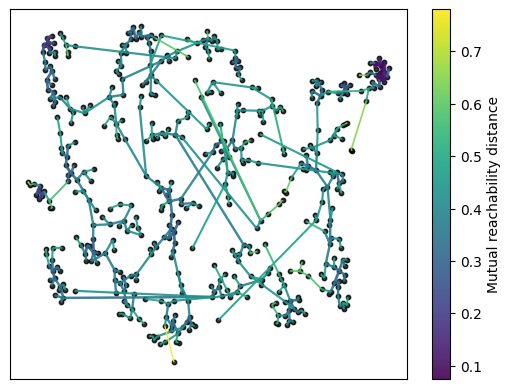

In [65]:
# 훈련된 모델을 사용하여 minimum_spanning_tree 생성
cluster.minimum_spanning_tree_.plot(edge_alpha=0.9, edge_cmap='viridis', node_size=10, edge_linewidth=1)

<Axes: ylabel='$\\lambda$ value'>

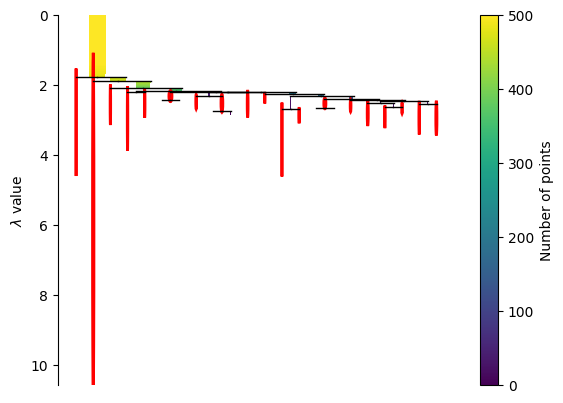

In [66]:
# 훈련된 모델을 사용하여 condensed_tree 생성
# cluster도 함께 보기위해 select_clusters=True 설정
cluster.condensed_tree_.plot(select_clusters=True)

In [67]:
# 클러스터별 주제어 추출확인
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

# Copyright (c) 2021 KPFBERT
# source: github.com/KPFBERT/kpfSBERT_Clustering

In [68]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(lst_sent))

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,216
6,5,45
13,12,31
9,8,27
2,1,21
17,16,17
15,14,16
7,6,13
8,7,12
14,13,12


In [69]:
pd.DataFrame(top_n_words)

,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,"(금리, 0.01986740106510416)","(정비, 0.14259195023249505)","(마트, 0.5082435512949791)","(지수, 0.40173835210859726)","(수준, 0.3401759135154909)","(중국, 0.23856730135052057)","(배터리, 0.0515119707604932)","(컬리, 0.08977985232296336)","(사진, 0.11009748535453331)","(시멘트, 0.06705991301808752)","(가격, 0.16094379124341004)","(아파트, 0.22582425908254314)","(주택, 0.11998492512774943)","(뱅크, 0.09729803662923191)","(신약, 0.13703560204698434)","(부회장, 0.06325301839260657)","(산업, 0.15315431691638356)","(치즈, 0.09436824151614942)","(투입, 0.13955061169660885)","(메타, 0.140807224121672)"
1,"(달러, 0.019630849657892285)","(강남, 0.1323102364591573)","(연고, 0.3270846367590627)","(지상, 0.36809739452414975)","(증가, 0.3109174581571246)","(이후, 0.21517508357504952)","(차량, 0.04625465947139101)","(물량, 0.08977985232296336)","(혼합, 0.10618194072812012)","(목재, 0.053291623018271686)","(러시아, 0.13803652294655616)","(매수, 0.16471675812329034)","(진단, 0.1030066270420285)","(카카오, 0.07805026992695535)","(바이오, 0.12335277283896674)","(자리, 0.060329740427791594)","(폐지, 0.1228569063665038)","(라볶이, 0.07915268421807052)","(삼성전자, 0.11854615167964079)","(버스, 0.1328893689165771)"
2,"(서울, 0.018171024429380966)","(계약, 0.10117300876107274)","(폭우, 0.3270846367590627)","(창고, 0.36809739452414975)","(스텝, 0.2702003521053127)","(마감, 0.19676906960592624)","(전기차, 0.041209576608394555)","(낙농, 0.08318692373583875)","(코오롱, 0.10618194072812012)","(시공사, 0.053291623018271686)","(부진, 0.13803652294655616)","(심리, 0.14542642692593974)","(임대, 0.1030066270420285)","(은행, 0.07361428053426039)","(지출, 0.09859751639039724)","(회장, 0.057941248417390435)","(복무, 0.10224927625670825)","(차돌, 0.07915268421807052)","(메모리, 0.10348358665131828)","(지능, 0.10131120950205956)"
3,"(금융, 0.017770274083183452)","(경우, 0.09870809031785745)","(배추밭, 0.3270846367590627)","(나스닥, 0.34106638731693883)","(고위, 0.2702003521053127)","(종가, 0.185704374511627)","(공장, 0.03957806379592069)","(채소, 0.08318692373583875)","(출처, 0.10618194072812012)","(사업, 0.05067311167392123)","(원료, 0.12789989524385206)","(집값, 0.11624128248131044)","(안전, 0.09272154736888776)","(금리, 0.058621134938382426)","(공간, 0.09859751639039724)","(센터, 0.05124920967809798)","(스왑, 0.10224927625670825)","(인플레이션, 0.05662094490968965)","(폐기물, 0.0930181056318924)","(퍼블리셔, 0.10131120950205956)"
4,"(투자, 0.017392436606459595)","(전셋값, 0.09519760203210768)","(절충안, 0.3270846367590627)","(감소, 0.26080153369520975)","(콘도미니엄, 0.2702003521053127)","(수준, 0.15046242328569792)","(현대, 0.0350069172745248)","(식품, 0.0719162378730754)","(국장, 0.10618194072812012)","(건물, 0.05029493476356564)","(하반기, 0.10043458802714932)","(위축, 0.11624128248131044)","(국토, 0.09272154736888776)","(금융, 0.04743966306716524)","(공구, 0.09135706803132289)","(네트, 0.04822236609486678)","(헤지, 0.10224927625670825)","(로제, 0.045257876375920054)","(소각로, 0.0930181056318924)","(파인, 0.10131120950205956)"
5,"(사업, 0.01500653589932063)","(루카, 0.09519760203210768)","(주장, 0.29060320620327607)","(가입자, 0.2071536032807397)","(바닷가, 0.2702003521053127)","(배럴, 0.11951169420042676)","(항생제, 0.03433554234734283)","(한국, 0.05596779473467335)","(한경, 0.09838453480296312)","(지구, 0.04797052277070929)","(수요, 0.0932425362158548)","(지역, 0.09311260271987656)","(공공, 0.07411356936727846)","(지수, 0.04726333554218791)","(여행, 0.08621988816611252)","(커리어, 0.04822236609486678)","(보건, 0.10224927625670825)","(세탁기, 0.045257876375920054)","(개발, 0.08197320616644789)","(가입, 0.10131120950205956)"
6,"(영업, 0.014901482575244845)","(갱신, 0.09519760203210768)","(얘기, 0.29060320620327607)","(저온, 0.2071536032807397)","(상향, 0.2702003521053127)","(이웃, 0.11951169420042676)","(기아, 0.03433554234734283)","(제공, 0.05405262342318744)","(감독, 0.09838453480296312)","(선정, 0.04797052277070929)","(증가, 0.08938876922017333)","(시장, 0.08680649038807786)","(공실, 0.07411356936727846)","(최대, 0.04726333554218791)","(건설, 0.07173899144796379)","(여성, 0.04822236609486678)","(월마트, 0.10224927625670825)","(세포, 0.045257876375920054)","(에너지, 0.07518484648622466)","(프리먼, 0.1013112095020

# End